### EDA/preprocessing/data load

In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import os
import re

from tensorflow.image import resize_with_pad
from tensorflow.keras.preprocessing.image import (
    load_img, 
    img_to_array, 
    ImageDataGenerator,
    array_to_img,
    save_img
)

In [34]:
#setting data source

DIR_PATH = os.path.abspath("garbage_classification/")
folders = os.listdir(DIR_PATH)
folders.pop(0) #removing .DS_Store
folders

['green-glass', 'white-glass', 'brown-glass', 'plastic']

In [35]:
# finding the largest image shape for reference
# to select the right target size

max_img_size = 0
max_img_shape = None

for folder in folders:
    folder_path = os.path.join(DIR_PATH, folder)
    imgs = os.listdir(folder_path)
    
    for img in imgs:
        img_path = os.path.join(folder_path, img)

        img = load_img(img_path)
        img_shape = img_to_array(img).shape
        width, height, __ = img_shape
        curr_img_size = width * height
        
        if curr_img_size > max_img_size or not max_img_size:
            max_img_size = curr_img_size
            max_img_shape = img_shape
            
max_img_shape

(384, 512, 3)

In [36]:
#function of resizing and padding images to be used later in the model 

TARGET_HEIGHT = 128
TARGET_WIDTH = 128

def preprocess_img_to_arr(img, target_height = TARGET_HEIGHT, target_width = TARGET_WIDTH):
    img_arr = np.asarray(img)
    img_tensor = tf.convert_to_tensor(img_arr)

    new_img_arr = resize_with_pad(
        img_tensor, 
        target_height, 
        target_width, 
        method = 'bicubic',
        antialias = True
    )
    
    return new_img_arr

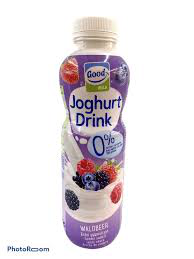

In [37]:
img = load_img('garbage_classification/plastic/plastic1.jpg')
img

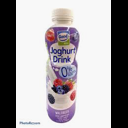

In [38]:
array_to_img(preprocess_img_to_arr(img))

In [41]:
# store preprocessed images in new folder
NEW_DIR_PATH = os.path.abspath('new_images')

for folder in folders:
    folder_path = os.path.join(DIR_PATH, folder)
    new_folder_path = os.path.join(NEW_DIR_PATH, folder)
    
    if not os.path.exists(new_folder_path):
        os.makedirs(new_folder_path)
    
    imgs = os.listdir(folder_path)
    
    for img in imgs:
        img_path = os.path.join(folder_path, img)
        new_img_path = os.path.join(new_folder_path, img)
        
        img = load_img(img_path)
        img_arr = preprocess_img_to_arr(img)
        save_img(new_img_path, img_arr)


In [43]:
# creating a generator for the images

datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    vertical_flip = True,

generator = datagen.flow_from_directory(
    'new_images',
    target_size = (TARGET_HEIGHT, TARGET_WIDTH),
    batch_size = 32,
    class_mode = 'categorical',
    interpolation='nearest',
    seed = 42,
    shuffle = True
)

Found 2876 images belonging to 4 classes.


In [45]:
# cleaning the names of the classes

def clean_name(name):
    name = (
        re
        .sub(r'\d+', '', name) # remove digits
        .strip() # remove whitespace
    )
    return name


label_to_name_dict = {label: clean_name(name) for name, label in generator.class_indices.items()}
label_to_name_dict

{0: 'brown-glass', 1: 'green-glass', 2: 'plastic', 3: 'white-glass'}

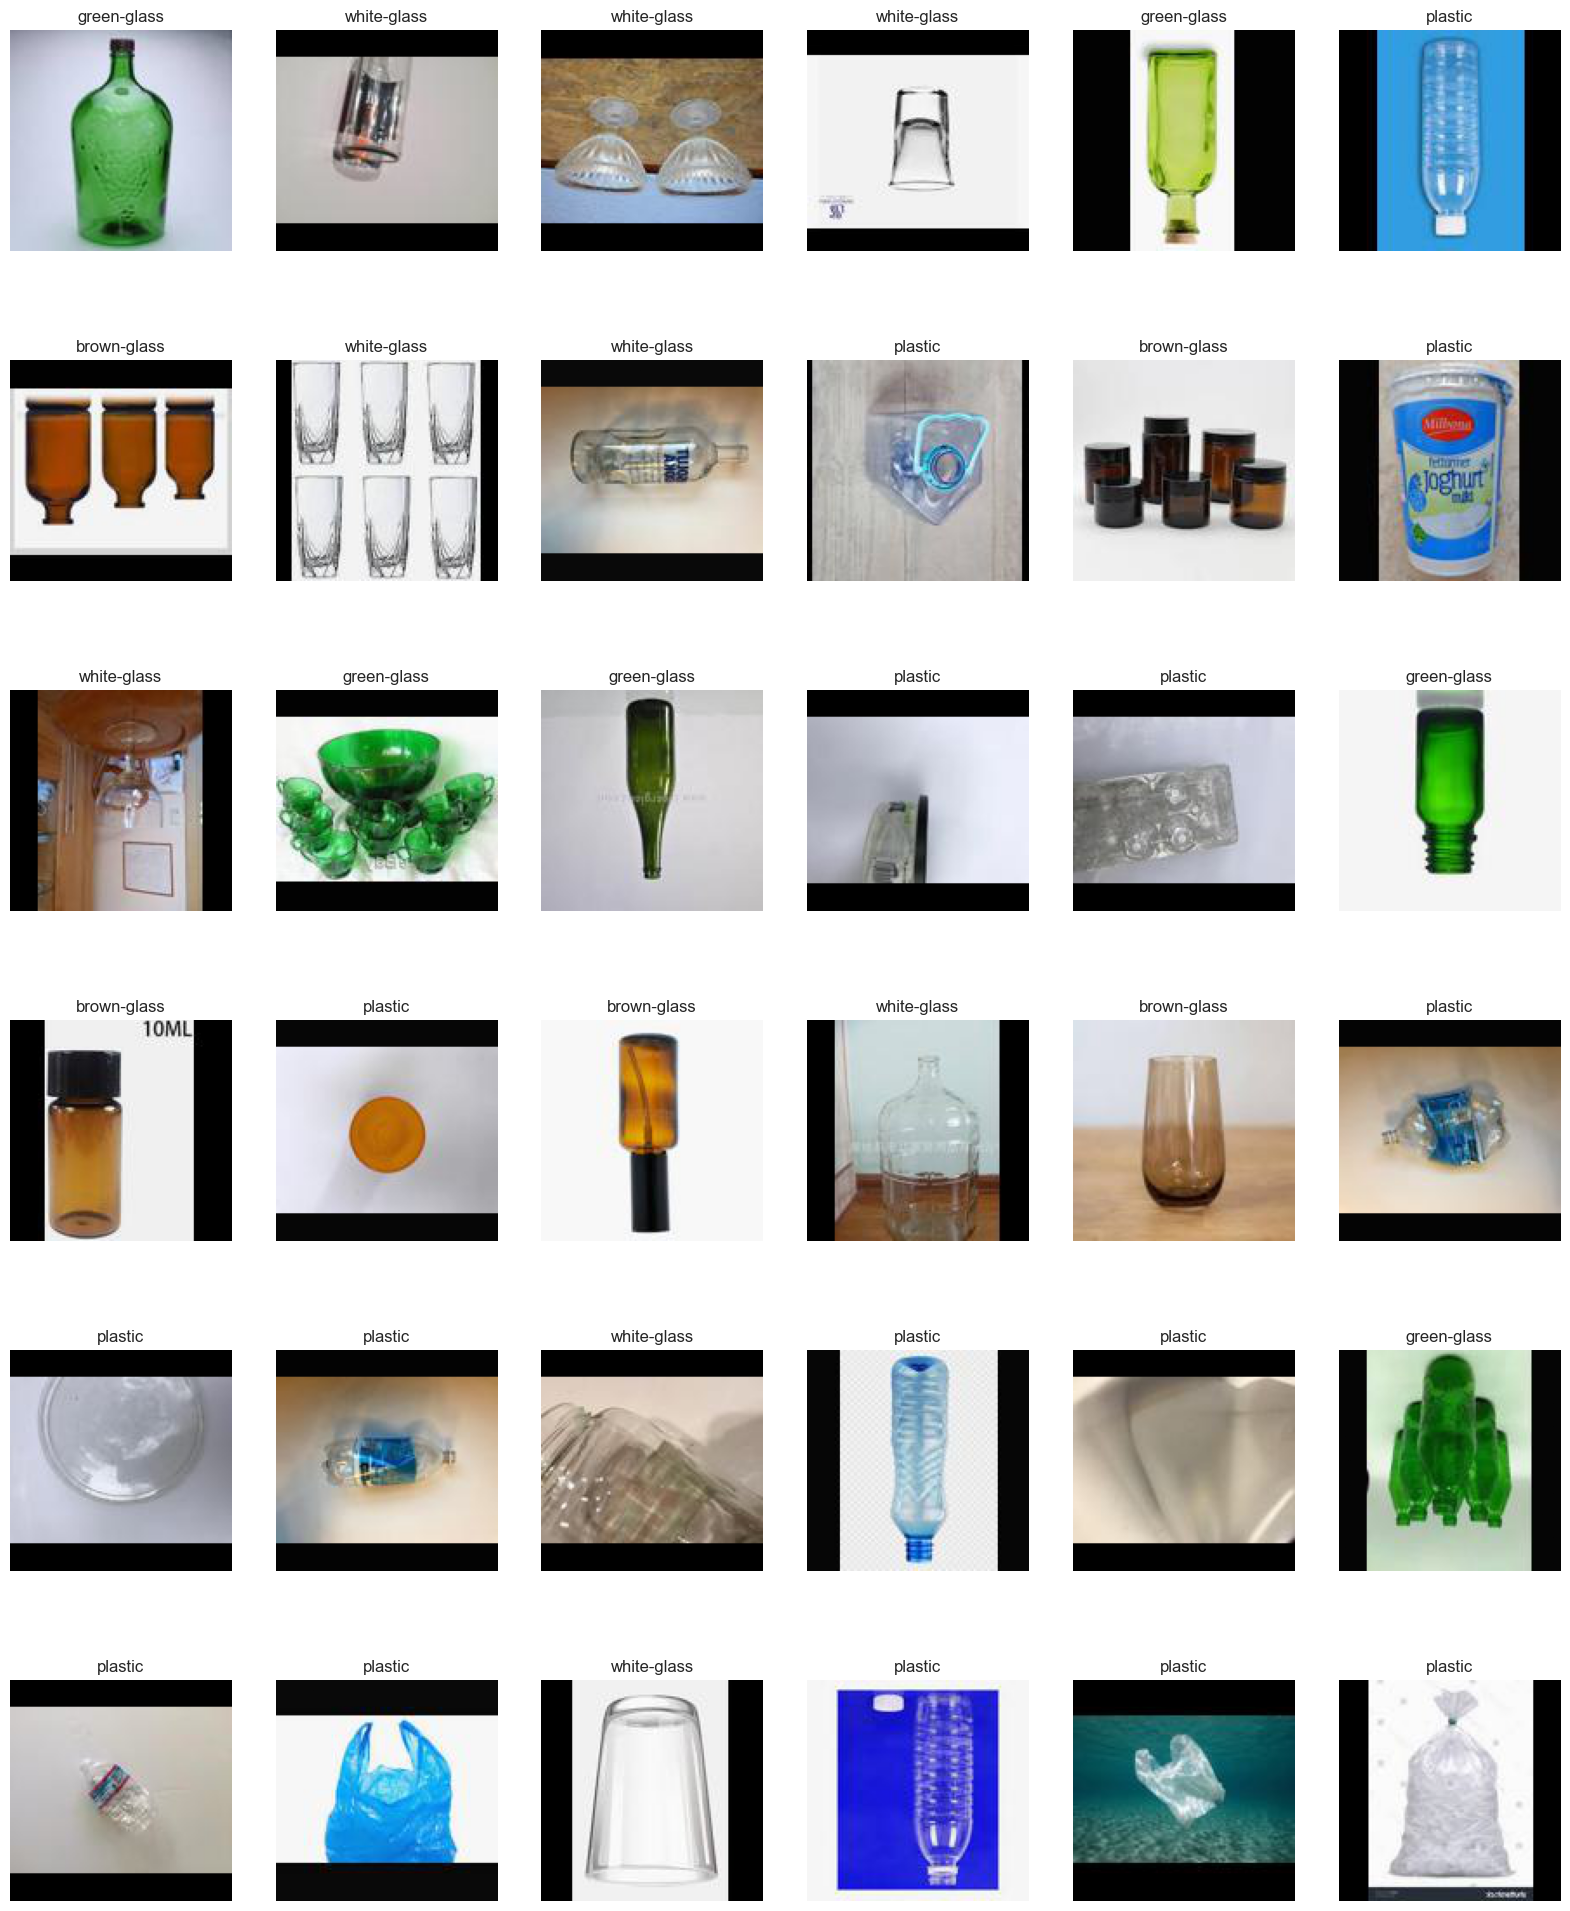

In [51]:
# sample a few images
num_rows, num_cols = 6, 6
num_imgs = num_rows * num_cols

plt.figure(figsize=(20, 25))

# these images can be used for both non-deep-learning and deep-learning applications
for idx in range(num_imgs):
    img, label_arr = generator.next()
    label = np.argmax(label_arr)
    name = label_to_name_dict[label]
    plt.subplot(num_rows, num_cols, idx + 1, title = name)

    plt.imshow(img[0])
    plt.axis('off')

In [50]:
#counting the number of images in each class

for folder in folders:
    folder_path = os.path.join(NEW_DIR_PATH, folder)
    imgs = os.listdir(folder_path)
    print(f"{folder}: {len(imgs)}")


green-glass: 629
white-glass: 775
brown-glass: 607
plastic: 865


Images are ready to be loaded into the dataframe. There are a total of 2527 images, with 865 plastic images and 1662 glass images. There is a class imbalance present which can be addressed later.

In [61]:
#data loading and preprocessing for the model

img_array=[]
class_name=[]
img_name=[]

def create_image_df(img_folder): # path_resized_baseline_train
   
    for img_class_subfolder in os.listdir(img_folder):
        if img_class_subfolder == '.DS_Store':
            continue
        for file in os.listdir(os.path.join(img_folder, img_class_subfolder)):
       
            image_path= os.path.join(img_folder, img_class_subfolder,  file)
            
            img = tensorflow.keras.utils.load_img(image_path, target_size=(128, 128),color_mode = "rgb")
            x = tensorflow.keras.utils.img_to_array(img)
            x = x/255
            x = np.expand_dims(x, axis=0)
            x = np.transpose(x.flatten())
            
            # append to list
            img_array.append(x)
            class_name.append(img_class_subfolder)
            img_name.append(file)
    
    # create df and concatenate 3 elements
    df_img_array = pd.DataFrame(data = img_array)
    df_name = pd.DataFrame({'img_id':img_name})    
    df_class = pd.DataFrame({'class_name':class_name})
            
    # merge dataframes
    img_df_temp = df_img_array.merge(df_name, left_index=True, right_index=True)
    img_df = img_df_temp.merge(df_class, left_index=True, right_index=True)
               
    return img_df

In [62]:
df = create_image_df(NEW_DIR_PATH)

In [63]:
#df with the images and their classes
df

,0,1,2,3,4,5,6,7,8,9,...,49144,49145,49146,49147,49148,49149,49150,49151,img_id,class_name
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,green-glass221.jpg,green-glass
1,0.015686,0.015686,0.015686,0.015686,0.015686,0.015686,0.015686,0.015686,0.015686,0.015686,...,0.015686,0.015686,0.015686,0.015686,0.015686,0.015686,0.015686,0.015686,green-glass547.jpg,green-glass
2,0.898039,0.898039,0.898039,0.878431,0.878431,0.878431,0.898039,0.898039,0.898039,0.956863,...,0.901961,0.901961,0.886275,0.886275,0.886275,0.901961,0.901961,0.901961,green-glass553.jpg,green-glass
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,green-glass235.jpg,green-glass
4,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,...,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,green-glass209.jpg,green-glass
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2871,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,...,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,plastic405.jpg,plastic
2872,0.015686,0.015686,0.015686,0.015686,0.015686,0.015686,0.015686,0.015686,0.015686,0.015686,...,0.015686,0.015686,0.015686,0.015686,0.015686,0.015686,0.015686,0.015686,plastic411.jpg,plastic
2873,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,plastic377.jpg,plastic
2874,0.027451,0.027451,0.027451,0.027451,0.027451,0.027451,0.027451,0.027451,0.027451,0.027451,...,0.027451,0.027451,0.027451,0.027451,0.027451,0.027451,0.027451,0.027451,plastic439.jpg,plastic


In [64]:
# reordering columns
cols_to_order = ['img_id', 'class_name']
new_columns = cols_to_order + (df.columns.drop(cols_to_order).tolist())
image_df = df[new_columns]
image_df.head()

,img_id,class_name,0,1,2,3,4,5,6,7,...,49142,49143,49144,49145,49146,49147,49148,49149,49150,49151
0,green-glass221.jpg,green-glass,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,green-glass547.jpg,green-glass,0.015686,0.015686,0.015686,0.015686,0.015686,0.015686,0.015686,0.015686,...,0.015686,0.015686,0.015686,0.015686,0.015686,0.015686,0.015686,0.015686,0.015686,0.015686
2,green-glass553.jpg,green-glass,0.898039,0.898039,0.898039,0.878431,0.878431,0.878431,0.898039,0.898039,...,0.952941,0.901961,0.901961,0.901961,0.886275,0.886275,0.886275,0.901961,0.901961,0.901961
3,green-glass235.jpg,green-glass,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,green-glass209.jpg,green-glass,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,...,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608


In [65]:
#pickle df
image_df.to_pickle("image_df.pickle")